In [1]:
#####################################################################################################
#####################################################################################################
####################### Import dependencies
#####################################################################################################
#####################################################################################################

import bovespa
import pandas as pd
import csv
import fnmatch
import re
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from os import listdir, path
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandasql import sqldf

In [37]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Constants
CONST_directory                            = "../data"
CONST_fdata_regex                          = "*.txt"
CONST_fcodes_not_regex                     = "\d\w|\d\d"
CONST_fcodes_regex                         = "^\w\w\w\w\d$"
CONST_ma_days                              = 21
CONST_sdv_times                            = 2
CONST_operation_start_days                 = 1
CONST_stop_buy                             = 0.1
CONST_comission                            = 5.0
CONST_amount                               = 50000.0
CONST_fig_x                                = 20
CONST_fig_y                                = 8

CONST_formula_label                        = "FORMULA"
CONST_date_label                           = "DATE"
CONST_ratio_label                          = "RATIO"
CONST_price_label                          = "PRICE"
CONST_cumulative_suffix_label              = "_CUMULATIVE"
CONST_buydate_label                        = "Buy Date:"
CONST_selldate_label                       = "Sell Date:"
CONST_file_label                           = "Arquivo:" 
CONST_stock1_label                         = "Stock 1:"
CONST_stock2_label                         = "Stock 2:"
CONST_operation_label                      = "Operation"
CONST_bbands_upper_label                   = "BBANDS_UPPER"
CONST_bbands_middleupper_label             = "BBANDS_MIDDLEUPPER"
CONST_bbands_base_label                    = "BBANDS_BASE"
CONST_bbands_middlelower_label             = "BBANDS_MIDDLELOWER"
CONST_bbands_lower_label                   = "BBANDS_LOWER"
CONST_bbands_trend_label                   = "BBANDS_TREND"
CONST_bbands_result_label                  = "BBANDS_TREND_PRICE"
CONST_bbands_cost_label                    = "BBANDS_COST"
CONST_revenue_prefix_label                 = "STOCK_REVENUE_"
CONST_cost_prefix_label                    = "STOCK_COST_"
CONST_result_prefix_label                  = "STOCK_RESULT_" 
CONST_gain_prefix_label                    = "STOCK_GAIN_"
CONST_stocks_prefix_label                  = "STOCK_QUANTITY_"
CONST_netincome_ratio_value_label          = "NETINCOME_VALUE_RATIO"
CONST_netincome_ratio_percent_label        = "NETINCOME_PERCENT_RATIO"

pysqldf = lambda q: sqldf(q, globals())

In [3]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Classes
class Indicator:
    @classmethod
    def revenue(self, df, date_attr, price_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        comission = (kwargs.get("comission") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # Calculate first investment
        buy_line     = df[df[date_attr] == buy_date]
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            # Buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd
            
        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
    
    @classmethod
    def revenue_with_ratio(self, df, date_attr, stock1_price_attr, stock2_price_attr, bb_ratio_attr, bb_base_attr, bb_trend_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        comission = (kwargs.get("comission") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # It defines the first buy of stock for net income calculation
        buy_line  = df[df[date_attr] == buy_date]
        
        if (buy_line[bb_base_attr]).item() and ((buy_line[bb_ratio_attr]).item() > (buy_line[bb_base_attr]).item()):
            trend = 1
        else:
            trend = -1
        
        price_attr = stock1_price_attr if trend == -1 else stock2_price_attr
        
        # Calculate first investment
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
#         print("IDX", "\tQTD", "\tS", "\tR$", "\tEXEC")
#         print(idx, (lot_qtd * lot_size), price_attr, (lot_price/lot_size), "Buy")
#         print(idx, Stocks[idx].item(), price_attr, (lot_price/lot_size), Result[idx].item(), Cost[idx].item(), "Result")          
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            # Change, buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0
#                 print(idx, (lot_qtd*lot_size), price_attr, (lot_price/lot_size), "Sell all")

            elif (value[bb_trend_attr] == 1 and trend == -1) or (value[bb_trend_attr] == -1 and trend == 1):
                trend = 1 if trend == -1 else -1
                price_attr = stock2_price_attr if trend == 1 else stock1_price_attr
                
                temp_cost      = cost + (lot_price * lot_qtd) - comission
                temp_result    = result + temp_cost
                temp_lot_price = value[price_attr] * lot_size
                temp_lot_qtd   = math.floor(temp_result / temp_lot_price)
                
                # Can sell and buy?
                if (temp_lot_qtd > 0):
                    # Sell
                    cost    = temp_cost
                    result  = temp_result
                    stocks  = 0
                    lot_qtd = 0
#                     print("CHANGE:", trend, price_attr, lot_size, lot_qtd, cost, result)                
#                     print(idx, (lot_qtd * lot_size), price_attr, (lot_price/lot_size), "Sell")

                    # Buy
                    lot_price = temp_lot_price
                    lot_qtd   = temp_lot_qtd
                    amount    = result - (lot_price * lot_qtd)
                    prev_cost = cost
                    cost      -= comission + (lot_price * lot_qtd)
                    result    = amount - prev_cost + (lot_price * lot_qtd)
#                     print("CHANGE:", trend, price_attr, lot_size, lot_qtd, cost, result)                  
#                     print(idx, (lot_size * lot_qtd), price_attr, (lot_price/lot_size), "Buy")                
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
#                 print(idx, (lot_size * lot_qtd), price_attr, (lot_price/lot_size), "Buy")                  
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd
#             print(idx, Stocks[idx].item(), price_attr, (lot_price/lot_size), Result[idx].item(), Cost[idx].item(), "Result")  

        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
            
    @classmethod
    def bbands(self, df, date_attr, price_attr, n, nstd, nresult, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        comission = (kwargs.get("comission") or 5.0)
        
        MA = pd.Series(df[price_attr].rolling(window=n).mean())
        MSD = pd.Series(df[price_attr].rolling(window=n).std())
        
        Base = pd.Series(MA, name = (kwargs.get("base_name") or "BASE"))
        Middle_upper = pd.Series(MA + MSD * nstd/2, name = (kwargs.get("middle_upper_name") or "MIDDLE_UPPER"))
        Middle_lower = pd.Series(MA - MSD * nstd/2, name = (kwargs.get("middle_lower_name") or "MIDDLE_LOWER"))
        Upper = pd.Series(MA + MSD * nstd, name = (kwargs.get("upper_name") or "UPPER"))
        Lower = pd.Series(MA - MSD * nstd, name = (kwargs.get("lower_name") or "LOWER"))        
        
        Cost = pd.Series(0, index = Lower.index, name = (kwargs.get("cost_name") or "COST"))
        Trend = pd.Series(0, index = Lower.index, name = (kwargs.get("trend_name") or "TREND"))
        Result = pd.Series(None, index = Lower.index, name = (kwargs.get("result_name") or "RESULT"))
        
        last_result = None
        last_idx = 0
        last_trend = None
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            if idx >= n:
                # Trend/Result calculation
                if ((last_trend != 1) and 
                        ((df[price_attr][idx] > Upper[idx]) or 
                        ((last_trend != 1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] > Middle_upper[idx])) or
                        ((last_trend != 1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] > Base[idx])))):
                    Trend[idx] = 1
                elif ((last_trend != -1) and 
                        ((df[price_attr][idx] < Lower[idx]) or 
                        ((last_trend != -1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] < Middle_lower[idx])) or
                        ((last_trend != -1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] < Base[idx])))):
                    Trend[idx] = -1                                   
                    
                # Lower/Upper adjust based on trend    
                if (Trend[idx] == 1) and (Lower[idx] < Lower[idx-1]):
                    Lower[idx] = Lower[idx-1]
                elif (Trend[idx] == -1) and (Upper[idx] > Upper[idx-1]):
                    Upper[idx] = Upper[idx-1]
                
                # Update result
                if (Trend[idx] != 0):
                    Result[idx] = df[price_attr][idx]
                    Cost[idx] = -2 * comission 
                    last_result = Result[idx]
                    last_idx = idx
                    last_trend = Trend[idx]                    
                    
        return pd.concat([df[date_attr], Upper, Middle_upper, Base, Middle_lower, Lower, Result, Trend, Cost], join='outer', axis=1)

class Parser:
    def __init__(self, inpt, output=None):
        self.input = inpt
        self.output = output

    @classmethod
    def convert_record_to_dict(self, query):
        for rec in query:
            yield rec.info

    def get_query(self):
        bf = bovespa.File(self.input)
        return bf.query()

    def get_dataframe(self):
        return pd.DataFrame(self.convert_record_to_dict(self.get_query()))
    
class Select:
    def __init__(self, option=None, dropdown=None):
        self.option = option
        self.dropdown = dropdown
        
    def get_dropdown(self, options, description="Option:"):
        if not self.dropdown:
            w = widgets.Dropdown(options=options,description=description,value=options[0])
            w.observe(self.on_change)
            self.dropdown = w
            self.option = w.value
        
        return self.dropdown
    
    def on_change(self, change):      
        if change.name == "value" and change.type == "change":
            self.option = change.new    
            
class Reader(Select):
    @classmethod
    def get_files(self, where, regex):
        return sorted([name for name in listdir(where) if re.compile(fnmatch.translate(regex), re.IGNORECASE).match(name)])

In [4]:
#####################################################################################################
#####################################################################################################
####################### Select Bovespa file
#####################################################################################################
#####################################################################################################

file = Select()
display(file.get_dropdown(Reader.get_files(CONST_directory, CONST_fdata_regex), CONST_file_label))

Dropdown(description='Arquivo:', options=('COTAHIST_A05-11.TXT', 'COTAHIST_A15-18.TXT', 'COTAHIST_A2005.TXT', …

In [45]:
#####################################################################################################
#####################################################################################################
####################### Parse Bovespa file
#####################################################################################################
#####################################################################################################

p = Parser(path.join(CONST_directory, file.option))
d = p.get_dataframe()

codes = d.CODNEG
options = codes[
    np.logical_and(
        ~codes.str.contains(CONST_fcodes_not_regex),
        codes.str.contains(CONST_fcodes_regex)
    )].sort_values().unique()

stock1 = Select()
stock2 = Select()

display(stock1.get_dropdown(options, CONST_stock1_label))
display(stock2.get_dropdown(options, CONST_stock2_label))

Dropdown(description='Stock 1:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'AELP3', 'AFLT3', 'AFLU3', 'AGRO…

Dropdown(description='Stock 2:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'AELP3', 'AFLT3', 'AFLU3', 'AGRO…

In [46]:
#####################################################################################################
#####################################################################################################
####################### Select Buydate and Selldate
#####################################################################################################
#####################################################################################################

d_stock1 = d[codes == stock1.option]
d_stock1.index = range(len(d_stock1))
d_stock2 = d[codes == stock2.option]
d_stock2.index = range(len(d_stock2))

buy_date = Select()
sell_date = Select()

display(buy_date.get_dropdown(d_stock1.DATPRG, CONST_buydate_label))
display(sell_date.get_dropdown(d_stock1.DATPRG, CONST_selldate_label))

Dropdown(description='Buy Date:', options=(datetime.date(2016, 1, 4), datetime.date(2016, 1, 5), datetime.date…

Dropdown(description='Sell Date:', options=(datetime.date(2016, 1, 4), datetime.date(2016, 1, 5), datetime.dat…

In [48]:
#####################################################################################################
#####################################################################################################
####################### Generate Dataframe
#####################################################################################################
#####################################################################################################

CONST_formula = f"{stock1.option}/{stock2.option}"

stocks = pd.DataFrame(data={
    CONST_date_label: d_stock1.DATPRG,
    CONST_formula_label: CONST_formula,
    CONST_ratio_label: d_stock1.PREULT/d_stock2.PREULT,
    stock1.option: d_stock1.PREULT,
    stock2.option: d_stock2.PREULT    
})

bbands = Indicator.bbands(
    stocks,
    CONST_date_label,
    CONST_ratio_label, 
    CONST_ma_days, 
    CONST_sdv_times, 
    CONST_operation_start_days,
    comission = CONST_comission,
    upper_name = CONST_bbands_upper_label,
    middle_upper_name = CONST_bbands_middleupper_label,
    base_name = CONST_bbands_base_label,
    middle_lower_name = CONST_bbands_middlelower_label,
    lower_name = CONST_bbands_lower_label,
    trend_name = CONST_bbands_trend_label,
    result_name = CONST_bbands_result_label,
    cost_name = CONST_bbands_cost_label
)

result_start_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock1.option),
    cost_name = (CONST_cost_prefix_label + "START_" + stock1.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock1.option)
)

result_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock1.option),
    cost_name = (CONST_cost_prefix_label + stock1.option), 
    result_name = (CONST_result_prefix_label + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + stock1.option)
)

result_start_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,    
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock2.option), 
    cost_name = (CONST_cost_prefix_label + "START_" + stock2.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock2.option)
)

result_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock2.option), 
    cost_name = (CONST_cost_prefix_label + stock2.option), 
    result_name = (CONST_result_prefix_label + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + stock2.option)
)

df = pd.merge(stocks, bbands, on=CONST_date_label)
df = pd.merge(df, result_stock1, on=CONST_date_label)
df = pd.merge(df, result_start_stock1, on=CONST_date_label)
df = pd.merge(df, result_stock2, on=CONST_date_label)
df = pd.merge(df, result_start_stock2, on=CONST_date_label)

result_ratio = Indicator.revenue_with_ratio(
    df,
    CONST_date_label,
    stock1.option, 
    stock2.option, 
    CONST_ratio_label, 
    CONST_bbands_base_label, 
    CONST_bbands_trend_label,
    amount = CONST_amount,
    comission = CONST_comission,    
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    revenue_name = (CONST_revenue_prefix_label + "RATIO"),
    cost_name = (CONST_cost_prefix_label + "RATIO"), 
    result_name = (CONST_result_prefix_label + "RATIO"),
    stocks_name = (CONST_stocks_prefix_label + "RATIO")
)

result_start_ratio = Indicator.revenue_with_ratio(
    df,
    CONST_date_label,
    stock1.option, 
    stock2.option, 
    CONST_ratio_label, 
    CONST_bbands_base_label,
    CONST_bbands_trend_label,
    amount = CONST_amount,
    comission = CONST_comission,
    start = CONST_stop_buy,
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    revenue_name = (CONST_revenue_prefix_label + "START_RATIO"),
    cost_name = (CONST_cost_prefix_label + "START_RATIO"), 
    result_name = (CONST_result_prefix_label + "START_RATIO"),
    stocks_name = (CONST_stocks_prefix_label + "START_RATIO")
)

df = pd.merge(df, result_ratio, on=CONST_date_label)
df = pd.merge(df, result_start_ratio, on=CONST_date_label)

# Add cumulative columns
labels = [
    (CONST_revenue_prefix_label + "START_" + stock1.option), 
    (CONST_revenue_prefix_label + stock1.option),
    (CONST_revenue_prefix_label + "START_" + stock2.option),
    (CONST_revenue_prefix_label + stock2.option),
    (CONST_revenue_prefix_label + "START_RATIO"),
    (CONST_revenue_prefix_label + "RATIO"),
    (CONST_cost_prefix_label + "START_" + stock1.option), 
    (CONST_cost_prefix_label + stock1.option),
    (CONST_cost_prefix_label + "START_" + stock2.option),
    (CONST_cost_prefix_label + stock2.option),
    (CONST_cost_prefix_label + "START_RATIO"),
    (CONST_cost_prefix_label + "RATIO")    
]

labels_cum = [(x + CONST_cumulative_suffix_label) for x in labels]

for l in zip(labels_cum, labels):
    df[l[0]] = df[l[1]].cumsum()

In [44]:
result_start_stock1

,DATE,STOCK_RESULT_START_VALE5,STOCK_REVENUE_START_VALE5,STOCK_COST_START_VALE5,STOCK_QUANTITY_START_VALE5
0,2008-01-02,275.0,0.0,-19725.0,400
1,2008-01-03,555.0,280.0,0.0,400
2,2008-01-04,-161.0,-716.0,0.0,400
3,2008-01-07,-441.0,-280.0,0.0,400
4,2008-01-08,-85.0,356.0,0.0,400
5,2008-01-09,-45.0,40.0,0.0,400
6,2008-01-10,555.0,600.0,0.0,400
7,2008-01-11,-77.0,-632.0,0.0,400
8,2008-01-14,107.0,184.0,0.0,400
9,2008-01-15,-525.0,-632.0,0.0,400


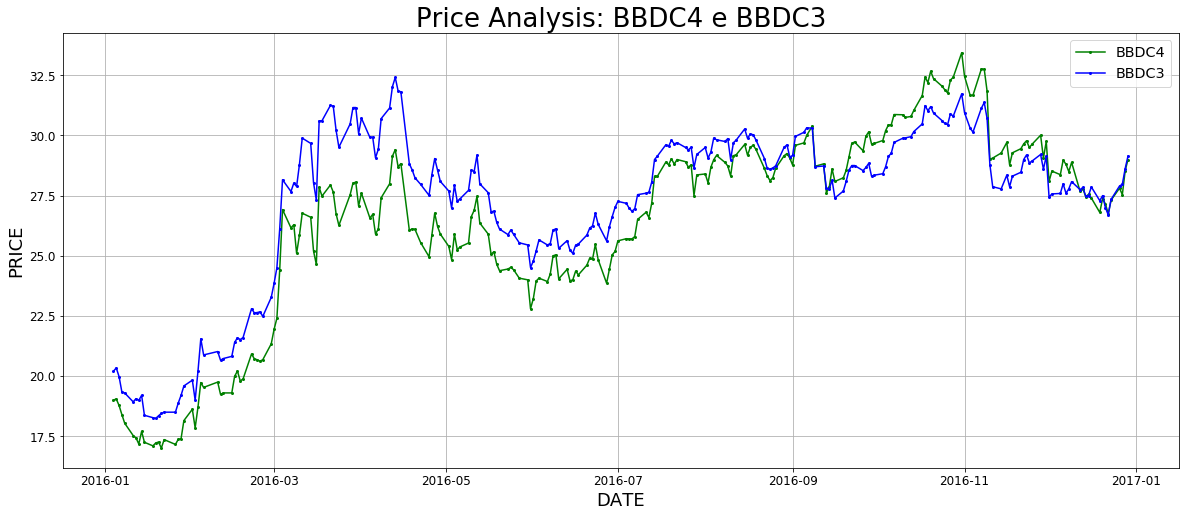

In [49]:
#####################################################################################################
#####################################################################################################
####################### Price Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(stocks[CONST_date_label], stocks[stock1.option], marker='o', markersize=2, color='green')
ax.plot(stocks[CONST_date_label], stocks[stock2.option], marker='o', markersize=2, color='blue')

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_price_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Price Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize="x-large")

# fig.savefig("test.png")
plt.show()

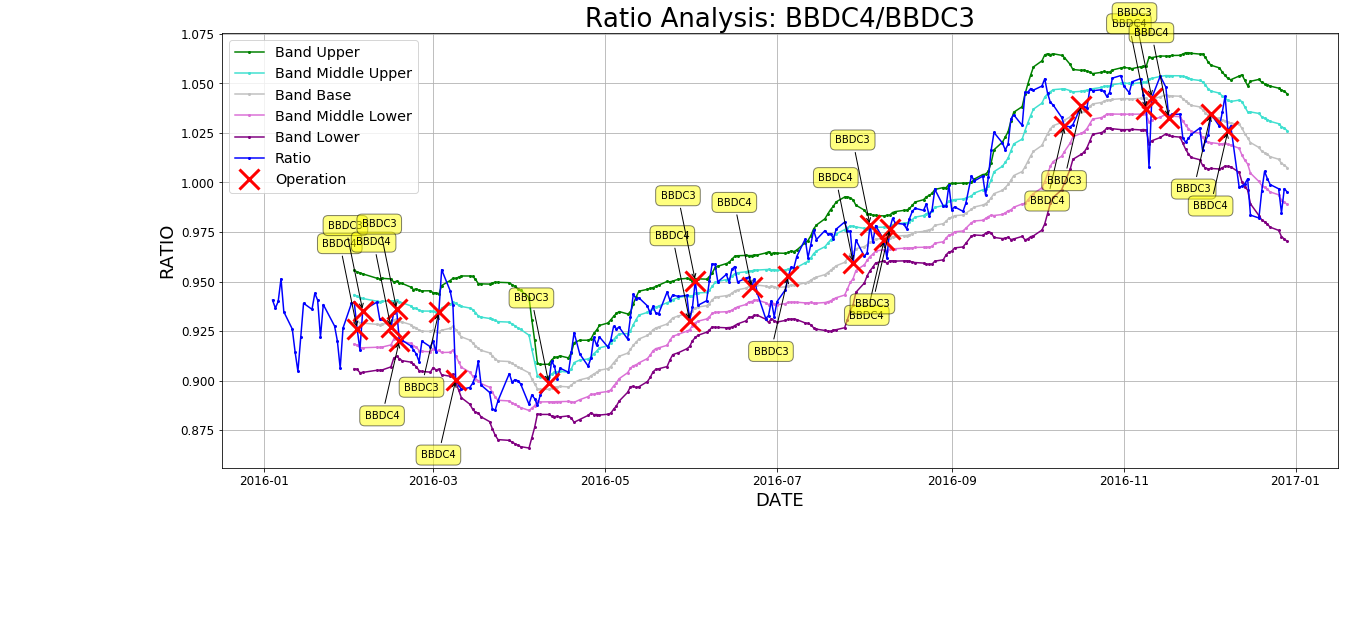

In [50]:
#####################################################################################################
#####################################################################################################
####################### Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_upper_label], marker='o', markersize=2, color='green', label='Band Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middleupper_label], marker='o', markersize=2, ls='solid', color='turquoise', label='Band Middle Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_base_label], marker='o', markersize=2, color='silver', label='Band Base')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middlelower_label], marker='o', markersize=2, ls='solid', color='orchid', label='Band Middle Lower')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_lower_label], marker='o', markersize=2, color='purple', label='Band Lower')
ax.plot(stocks[CONST_date_label], stocks[CONST_ratio_label], marker='o', markersize=2, color='blue', label='Ratio')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_result_label], marker='x', ls='None', ms=20, mec='r', mew=3, color='r', label=CONST_operation_label)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

def get_label(trend, y, stock1, stock2):
        opr = stock1 if trend == -1 else stock2
        return opr #+ "\n" + str(round(label, 2))
    
def get_position(x, y):
    return 0, ((x.toordinal() % 2) * 2 - 1) * 80

for rect in ax.lines:
    if rect.get_label() == CONST_operation_label:
        data = rect.get_data()
        xdata = data[0]
        ydata = data[1]
        
        for x, y in zip(xdata, ydata):
            if y:
                plt.annotate(
                    get_label((bbands[bbands[CONST_date_label] == x][CONST_bbands_trend_label]).item(), y, stock1.option, stock2.option),
                    xy=(x, y), 
                    xytext= get_position(x, y),
                    textcoords='offset points', 
                    ha='right', 
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_ratio_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Ratio Analysis: " + CONST_formula, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

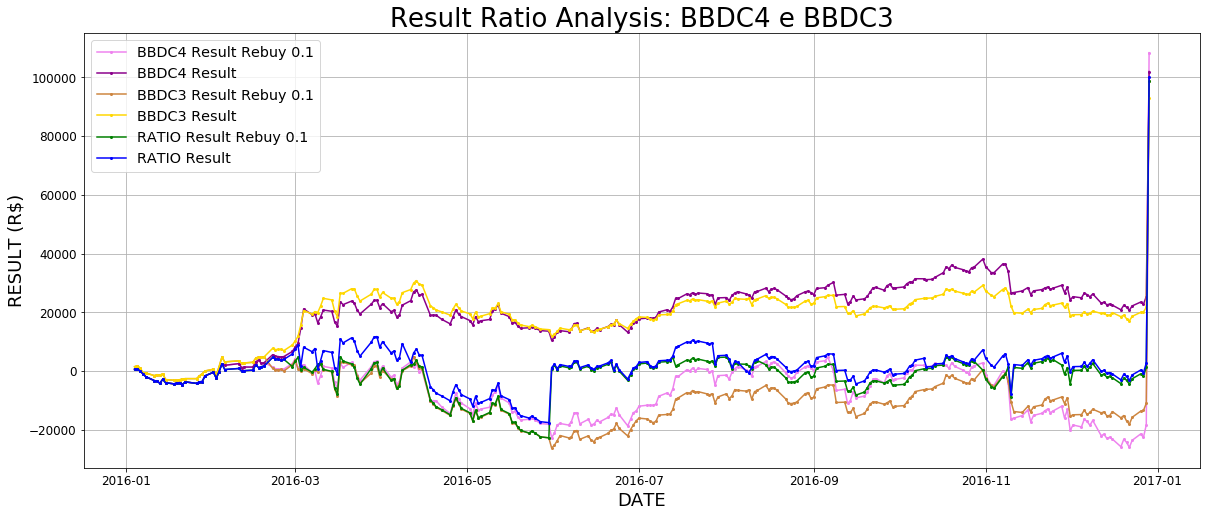

In [51]:
#####################################################################################################
#####################################################################################################
####################### Result Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(result_start_stock1[CONST_date_label], result_start_stock1[(CONST_result_prefix_label + "START_" + stock1.option)], marker='o', markersize=2, color='violet', label=(stock1.option + ' Result Rebuy ' + str(CONST_stop_buy)))
ax.plot(result_stock1[CONST_date_label], result_stock1[(CONST_result_prefix_label + stock1.option)], marker='o', markersize=2, color='darkmagenta', label=(stock1.option + ' Result'))
ax.plot(result_start_stock2[CONST_date_label], result_start_stock2[(CONST_result_prefix_label + "START_" + stock2.option)], marker='o', markersize=2, color='peru', label=(stock2.option + ' Result Rebuy ' + str(CONST_stop_buy)))
ax.plot(result_stock2[CONST_date_label], result_stock2[(CONST_result_prefix_label + stock2.option)], marker='o', markersize=2, color='gold', label=(stock2.option + ' Result'))
ax.plot(result_start_ratio[CONST_date_label], result_start_ratio[(CONST_result_prefix_label + "START_RATIO")], marker='o', markersize=2, color='green', label=(CONST_ratio_label + ' Result Rebuy ' + str(CONST_stop_buy)))
ax.plot(result_ratio[CONST_date_label], result_ratio[(CONST_result_prefix_label + "RATIO")], marker='o', markersize=2, color='blue', label=(CONST_ratio_label + ' Result'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("RESULT (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Result Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

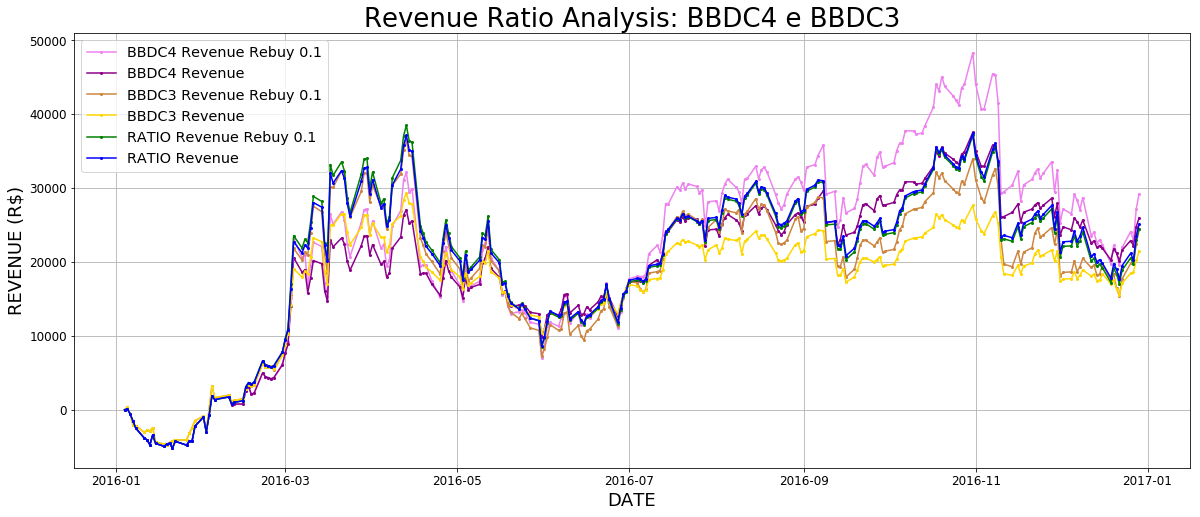

In [52]:
#####################################################################################################
#####################################################################################################
####################### Revenue Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + "START_" + stock1.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='violet', label=(stock1.option + ' Revenue Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + stock1.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='darkmagenta', label=(stock1.option + ' Revenue'))
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + "START_" + stock2.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='peru', label=(stock2.option + ' Revenue Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + stock2.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='gold', label=(stock2.option + ' Revenue'))
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + "START_RATIO" + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='green', label=(CONST_ratio_label + ' Revenue Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_revenue_prefix_label + "RATIO" + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='blue', label=(CONST_ratio_label + ' Revenue'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("REVENUE (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Revenue Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

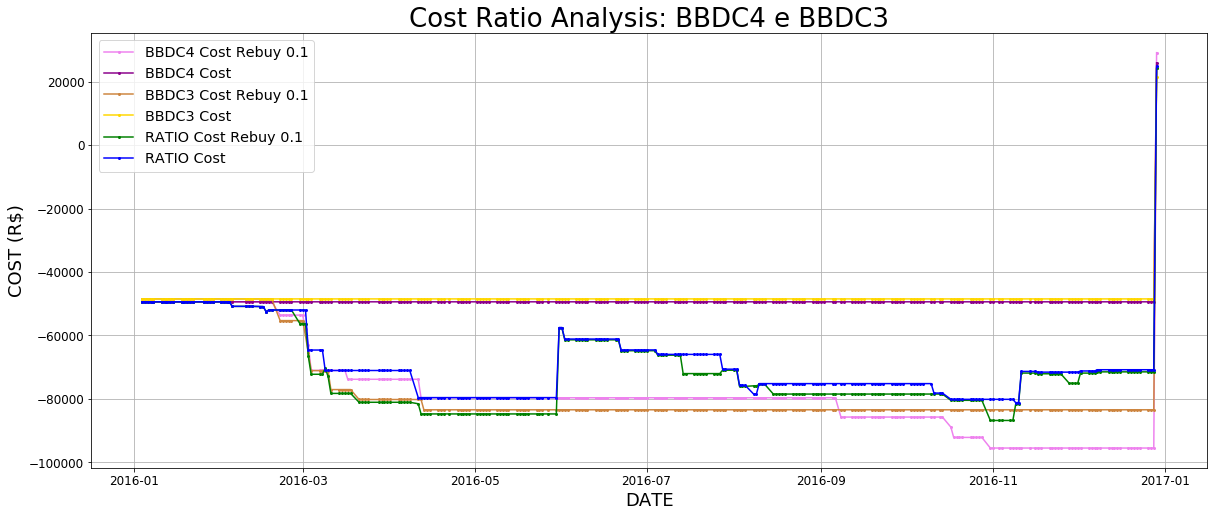

In [53]:
#####################################################################################################
#####################################################################################################
####################### Cost Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + "START_" + stock1.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='violet', label=(stock1.option + ' Cost Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + stock1.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='darkmagenta', label=(stock1.option + ' Cost'))
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + "START_" + stock2.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='peru', label=(stock2.option + ' Cost Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + stock2.option + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='gold', label=(stock2.option + ' Cost'))
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + "START_RATIO" + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='green', label=(CONST_ratio_label + ' Cost Rebuy ' + str(CONST_stop_buy)))
ax.plot(df[CONST_date_label], df[(CONST_cost_prefix_label + "RATIO" + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='blue', label=(CONST_ratio_label + ' Cost'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("COST (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Cost Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

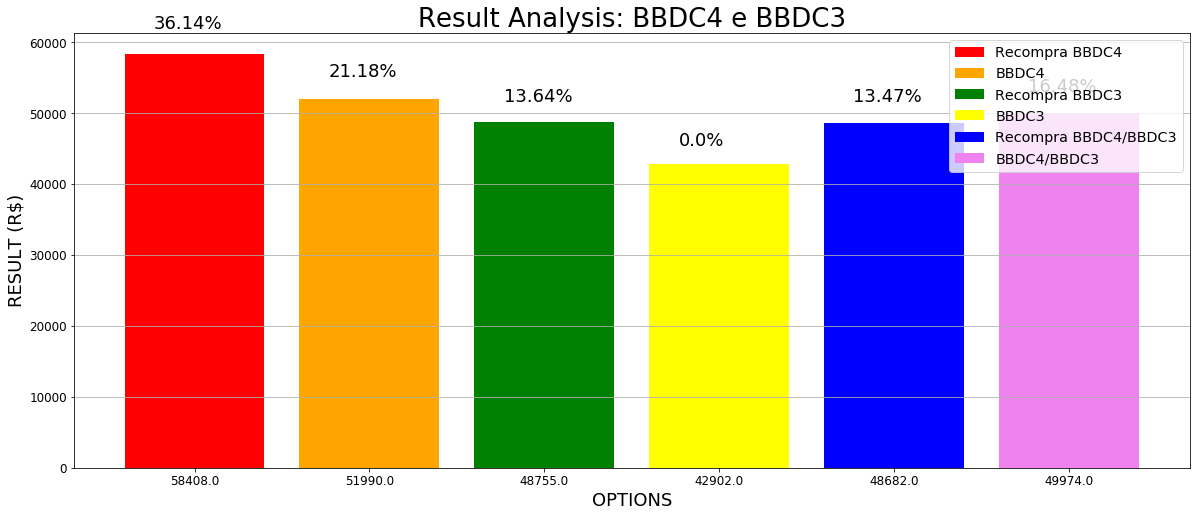

In [54]:
#####################################################################################################
#####################################################################################################
####################### Net Income Cumulative Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ind = np.arange(6)
step = ind[1] - ind[0]

values = [
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + "START_" + stock1.option)].item() - CONST_amount,
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + stock1.option)].item() - CONST_amount,
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + "START_" + stock2.option)].item() - CONST_amount,
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + stock2.option)].item() - CONST_amount,
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + "START_RATIO")].item() - CONST_amount,
    df[df[CONST_date_label] == sell_date.option][(CONST_result_prefix_label + "RATIO")].item() - CONST_amount
]

rects = ax.bar(ind, values)

rects[0].set_facecolor('r')
rects[1].set_facecolor('orange')
rects[2].set_facecolor('g')
rects[3].set_facecolor('yellow')
rects[4].set_facecolor('b')
rects[5].set_facecolor('violet')

ax.set_ylabel('RESULT (R$)', size=18)
ax.set_xlabel('OPTIONS', size=18)
ax.set_xticks(ind)
ax.set_xticklabels([round(x, 2) for x in values], size=50)
ax.set_title("Result Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.legend((rects[0], rects[1], rects[2], rects[3], rects[4], rects[5]), ("Recompra " + stock1.option, stock1.option, "Recompra " + stock2.option, stock2.option, "Recompra " + CONST_formula, CONST_formula), fontsize='x-large')

for rect in rects:
    y = rect.get_height()
    x = rect.get_x()
    text = str(round(((y-min(values))/abs(min(values)))*100, 2)) + "%"
    ax.text(x + step/len(values), 1.06*y, text, fontsize=18)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)
ax.set_autoscale_on(True)
ax.tick_params(labelsize="large")
ax.grid(axis="y")

# fig.savefig("test.png")
plt.show()